# Notebook 7b: 

simple plot ipsi contra combined win stay and lose switch conditions. recordings from the right side hemisphere. 

In [1]:
import os
from pathlib import Path
import pickle
import matplotlib.pyplot as plt

In [2]:
import Notebook_7_helper_functions as Nb_7

In [3]:
Nb_name= 'Notebook_7_b'
period_of_interest = "combined_periods_1"

In [4]:
mouse = 'T240'
data_day = '2019_09_27__T240'
date = '2019_09_27'

HowManyBack = 1

seq_str= "0a1b2a3a4abcde5a6a7b"

data_dir_output = "/Users/gilmandelbaum/Desktop/outPut"


#corresponds to the number 3 notebooks: 
y_axis_list = ["df_f","z_score","z_score_sliding_window"]

In [5]:
# Parameters
data_dir_input = "/Volumes/GilInVivoPaper.large/2.Photometry_in_str/2.dual_color_photo_full_data_set_analysis/"
data_dir_output = "/Volumes/GilInVivoPaper.large/2.Photometry_in_str/2.dual_color_photo_full_data_set_analysis/"
drop2blocks = "yes"
drop2lastblocks = "yes"
seq_str = "0a1d2a3a4abcde5a6a7b"
HowManyBack = 1
Nb0 = "a"
Nb1 = "d"
Nb2 = "a"
Nb3 = "a"
Nb4 = ["a", "b", "c", "d", "e"]
Nb5 = "a"
Nb6 = "a"
Nb7 = "b"
Tags = [
    "Reward_NoReward_tag",
    "ENL_tag",
    "Cue_to_Sel_tag",
    "Cue_to_Sel_fromPrevTrial_tag",
    "firstENLp_tag",
]
Timing = [600, 200, 15, 15, 20]
Start_or_end = ["start", "end", "start", "start", "start"]
y_axis_list = ["df_f", "z_score", "z_score_sliding_window"]
mouse = "T240"
data_day = "2019_09_27__T240"
date = "2019_09_27"
photo_day = "T240-145905"


same for all 7 notebooks

In [6]:
alphabet = ["a","b","c","d","e","f","g"]
y_axis = y_axis_list[alphabet.index(seq_str[:seq_str.index('4')][-1])]
print (y_axis)

df_f


In [7]:
version_to_import = seq_str[:seq_str.index('7')][-1]

In [8]:
root = Path(data_dir_output+"/"+mouse+"/"+data_day+'/'+str(HowManyBack)+"_Back")
d = mouse+"_"+date+"Notebook_6_"+version_to_import+"_"+'seq'+seq_str[:seq_str.index('7')]+'.pickle'

my_path = root / d 
print (my_path)
        
# open a file, where you stored the pickled data
fileToOpen = open(my_path, 'rb')
# load the pickle: 
PhotoData_perTrial_channels = pickle.load(fileToOpen)      

/Volumes/GilInVivoPaper.large/2.Photometry_in_str/2.dual_color_photo_full_data_set_analysis/T240/2019_09_27__T240/1_Back/T240_2019_09_27Notebook_6_a_seq0a1d2a3a4abcde5a6a.pickle


In [9]:
# stash result in a cache directory, for how many back. 
cache_dir_plt = os.path.join(data_dir_output+'/'+mouse+'/'+data_day, str(HowManyBack)+'_Back',"0.plots","session_plots_"+y_axis)
if not os.path.exists(cache_dir_plt):
    os.makedirs(cache_dir_plt)    

In [10]:
path_to_plot = cache_dir_plt+"/"+seq_str
print (path_to_plot)

/Volumes/GilInVivoPaper.large/2.Photometry_in_str/2.dual_color_photo_full_data_set_analysis//T240/2019_09_27__T240/1_Back/0.plots/session_plots_df_f/0a1d2a3a4abcde5a6a7b


# extract data of interest 

In [11]:
r_ls_combined_periods_1_d1= Nb_7.extract_data_of_interest_ipsi_contra_per_session(PhotoData_perTrial_channels,
                                                                      0,0,"combined_periods_1","d1 R")

In [12]:
r_ls_combined_periods_1_d2= Nb_7.extract_data_of_interest_ipsi_contra_per_session(PhotoData_perTrial_channels,
                                                                      0,0,"combined_periods_1","d2 R")

In [13]:
r_wr_combined_periods_1_d1= Nb_7.extract_data_of_interest_ipsi_contra_per_session(PhotoData_perTrial_channels,
                                                                      0,3,"combined_periods_1","d1 R")

In [14]:
r_wr_combined_periods_1_d2= Nb_7.extract_data_of_interest_ipsi_contra_per_session(PhotoData_perTrial_channels,
                                                                      0,3,"combined_periods_1","d2 R")

# calculate_mean_sem per session 

In [15]:
r_ls_combined_periods_1_d1_mean_sem = Nb_7.calculate_mean_sem (r_ls_combined_periods_1_d1)

In [16]:
r_ls_combined_periods_1_d2_mean_sem = Nb_7.calculate_mean_sem(r_ls_combined_periods_1_d2)

In [17]:
r_wr_combined_periods_1_d1_mean_sem = Nb_7.calculate_mean_sem(r_wr_combined_periods_1_d1)

In [18]:
r_wr_combined_periods_1_d2_mean_sem = Nb_7.calculate_mean_sem(r_wr_combined_periods_1_d2)

# make_sem_traces

In [19]:
r_ls_combined_periods_1_d1_sem_traces = Nb_7.make_sem_traces(r_ls_combined_periods_1_d1_mean_sem)

In [20]:
r_ls_combined_periods_1_d2_sem_traces = Nb_7.make_sem_traces(r_ls_combined_periods_1_d2_mean_sem)

In [21]:
r_wr_combined_periods_1_d1_sem_traces = Nb_7.make_sem_traces(r_wr_combined_periods_1_d1_mean_sem)

In [22]:
r_wr_combined_periods_1_d2_sem_traces = Nb_7.make_sem_traces(r_wr_combined_periods_1_d2_mean_sem)

# plot 

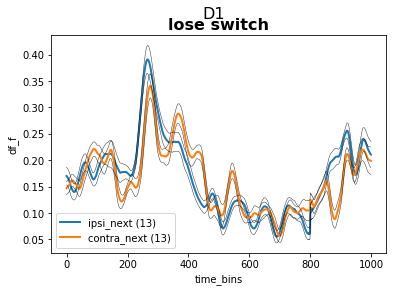

In [23]:
Nb_7.plot_ipsi_contra_together(r_ls_combined_periods_1_d1_mean_sem,
                              r_ls_combined_periods_1_d1_sem_traces,
                              "lose switch","D1",y_axis,path_to_plot)

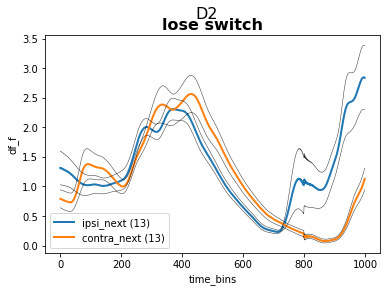

In [24]:
Nb_7.plot_ipsi_contra_together(r_ls_combined_periods_1_d2_mean_sem,
                              r_ls_combined_periods_1_d2_sem_traces,
                              "lose switch","D2",y_axis,path_to_plot)

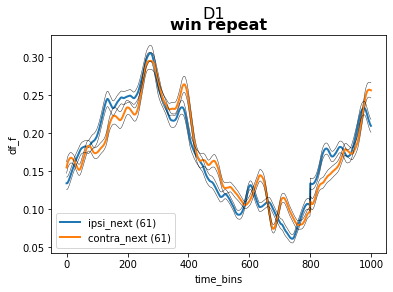

In [25]:
Nb_7.plot_ipsi_contra_together(r_wr_combined_periods_1_d1_mean_sem,
                              r_wr_combined_periods_1_d1_sem_traces,
                              "win repeat","D1",y_axis,path_to_plot)

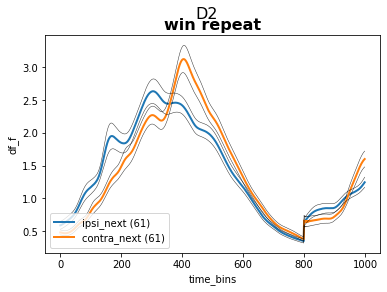

In [26]:
Nb_7.plot_ipsi_contra_together(r_wr_combined_periods_1_d2_mean_sem,
                              r_wr_combined_periods_1_d2_sem_traces,
                               "win repeat","D2",y_axis,path_to_plot)

In [27]:
root = Path(data_dir_output+"/"+mouse+"/"+data_day+'/'+str(HowManyBack)+"_Back")
d = mouse+"_"+date+Nb_name+'_seq'+seq_str+'.pickle'
my_path = root / d 
my_file = open(my_path, 'wb')
my_file = pickle.dump((),my_file)